In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
data = pd.read_csv("mnist_train.csv")

In [8]:
rownum  = 10
if -1<rownum <len(data):
    pixels = data.iloc[rownum,1:].values.reshape(28,28)
    image =np.array(pixels,dtype=np.uint8)


Text(0.5, 1.0, 'Original Image')

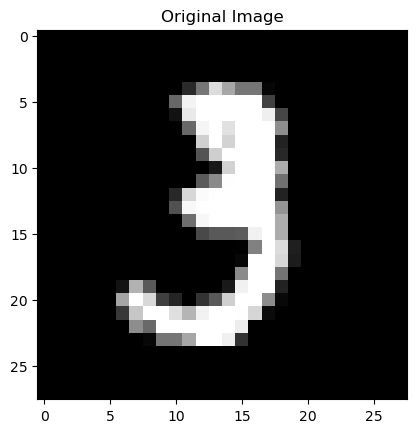

In [9]:
plt.imshow(image,cmap='gray')
plt.title("Original Image")

In [10]:
def region_growing(image, seed, threshold):
    rows, cols = image.shape
    segmented = np.zeros((rows, cols), dtype=np.uint8)  # Binary output image
    visited = np.zeros((rows, cols), dtype=bool)
    region = [seed]
    region_mean = image[seed]
    segmented[seed] = 255
    visited[seed] = True
    
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Neighboring pixels (N, S, W, E)

    while region:
        current_pixel = region.pop(0)
        for direction in directions:
            neighbor = (current_pixel[0] + direction[0], current_pixel[1] + direction[1])
            if (
                0 <= neighbor[0] < rows and
                0 <= neighbor[1] < cols and
                not visited[neighbor]
            ):
                diff = abs(int(image[neighbor]) - int(region_mean))
                if diff <= threshold:
                    segmented[neighbor] = 255
                    region.append(neighbor)
                    visited[neighbor] = True
                    region_mean = (region_mean + image[neighbor]) / 2  # Update mean

    return segmented


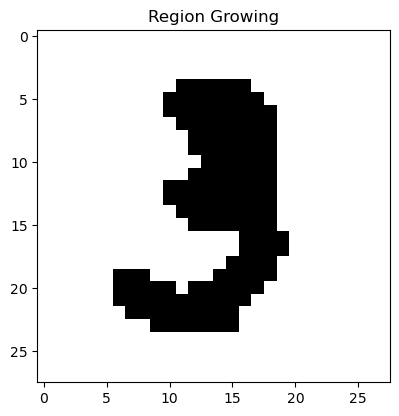

In [11]:
seed = (10, 10)  # Example seed position
threshold = 15  # Example threshold

# Region Growing
region_grown_image = region_growing(image, seed, threshold)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Region Growing")
plt.imshow(region_grown_image, cmap="gray")

In [12]:
def region_split_merge(image, threshold):
    rows, cols = image.shape

    def split(region):
        x, y, w, h = region
        sub_regions = []
        if w > 1 and h > 1:
            hw, hh = w // 2, h // 2
            sub_regions.append((x, y, hw, hh))       # Top-left
            sub_regions.append((x + hw, y, hw, hh))  # Top-right
            sub_regions.append((x, y + hh, hw, hh))  # Bottom-left
            sub_regions.append((x + hw, y + hh, hw, hh))  # Bottom-right
        return sub_regions

    def predicate(region):
        x, y, w, h = region
        sub_image = image[y:y + h, x:x + w]
        mean_intensity = np.mean(sub_image)
        max_intensity = np.max(sub_image)
        min_intensity = np.min(sub_image)
        return (max_intensity - min_intensity) <= threshold

    def split_recursive(region):
        if predicate(region):
            return [region]  # If region satisfies the threshold condition, return it as-is
        else:
            sub_regions = split(region)
            if not sub_regions:
                return [region]  # Cannot split further
            regions = []
            for sub_region in sub_regions:
                regions.extend(split_recursive(sub_region))
            return regions

    def merge(regions):
        merged = []
        while regions:
            base = regions.pop(0)
            x1, y1, w1, h1 = base
            to_merge = [base]
            i = 0
            while i < len(regions):
                x2, y2, w2, h2 = regions[i]
                # Check if two regions are adjacent
                if (
                    (x1 == x2 + w2 or x1 + w1 == x2 or y1 == y2 + h2 or y1 + h1 == y2)
                    and predicate((min(x1, x2), min(y1, y2), max(x1 + w1, x2 + w2) - min(x1, x2), max(y1 + h1, y2 + h2) - min(y1, y2)))
                ):
                    to_merge.append(regions.pop(i))
                else:
                    i += 1
            # Merge regions
            merged_x = min(r[0] for r in to_merge)
            merged_y = min(r[1] for r in to_merge)
            merged_w = max(r[0] + r[2] for r in to_merge) - merged_x
            merged_h = max(r[1] + r[3] for r in to_merge) - merged_y
            merged.append((merged_x, merged_y, merged_w, merged_h))
        return merged

    initial_region = (0, 0, cols, rows)
    regions = split_recursive(initial_region)
    merged_regions = merge(regions)

    # Create output image
    output = np.zeros_like(image)
    for region in merged_regions:
        x, y, w, h = region
        output[y:y + h, x:x + w] = 255  # Highlight merged regions in white

    return output

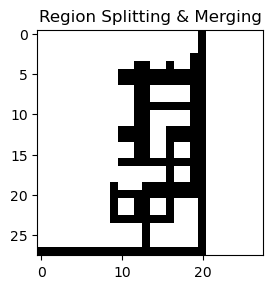

In [13]:
seed = (10, 10)  # Example seed position
threshold = 15  # Example threshold
# Region Splitting & Merging
region_split_merged_image = region_split_merge(image, threshold)
plt.subplot(1, 2, 2)
plt.title("Region Splitting & Merging")
plt.imshow(region_split_merged_image, cmap="gray")

plt.show()